In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("colorblind")
sns.set(font_scale = 1.1)
sns.set_style("whitegrid")

In [51]:
survey_vitals = pd.read_csv("survey_vitals_clean.csv").drop(columns = 'Unnamed: 0')
eval_med = pd.read_csv("evaluation_medical_clean.csv").drop(columns = 'Unnamed: 0')
history_env = pd.read_csv("history_env_clean.csv").drop(columns = 'Unnamed: 0')

### Clustering based on geopoint data

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sns
from sklearn.impute import SimpleImputer

In [53]:
survey_vitals.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,city,province,age,sex
0,XHCkKebF4a,single,Ama de casa,lessThanprimary,18.912087,-70.743801,NaN,NaN,34.0,female
1,ITCa1BkIiK,single,Ama de casa,someHighSchool,18.913084,-70.744104,NaN,NaN,52.0,female
2,AKjkw9A25J,single,Other,someHighSchool,18.913084,-70.744016,NaN,NaN,39.0,male
3,jk3fDkMvN9,single,Ama de casa,lessThanprimary,18.913325,-70.744557,NaN,NaN,39.0,female
4,pPgDn3kfGL,single,Estudiante,someHighSchool,18.913523,-70.745053,NaN,NaN,23.0,male


In [54]:
geo_loc = survey_vitals.loc[:, ["latitude", "longitude"]]

In [55]:
scaler = StandardScaler()

In [56]:
transformed_geo = scaler.fit_transform(geo_loc)

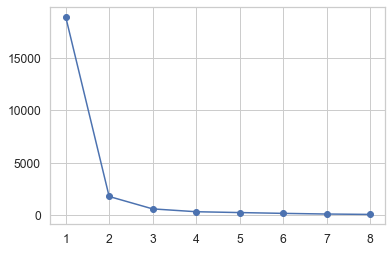

In [57]:
inertias = []
num_clusters = [1,2,3,4,5,6,7,8]
for k in num_clusters:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(transformed_geo)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, "-o")

In [58]:
model_KMeans =  KMeans(n_clusters = 4, random_state = 42)
labels = model_KMeans.fit_predict(transformed_geo)
labels

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

In [59]:
survey_vitals["clustersByLoc"] = list(labels)
survey_vitals.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,city,province,age,sex,clustersByLoc
0,XHCkKebF4a,single,Ama de casa,lessThanprimary,18.912087,-70.743801,NaN,NaN,34.0,female,1
1,ITCa1BkIiK,single,Ama de casa,someHighSchool,18.913084,-70.744104,NaN,NaN,52.0,female,1
2,AKjkw9A25J,single,Other,someHighSchool,18.913084,-70.744016,NaN,NaN,39.0,male,1
3,jk3fDkMvN9,single,Ama de casa,lessThanprimary,18.913325,-70.744557,NaN,NaN,39.0,female,1
4,pPgDn3kfGL,single,Estudiante,someHighSchool,18.913523,-70.745053,NaN,NaN,23.0,male,1


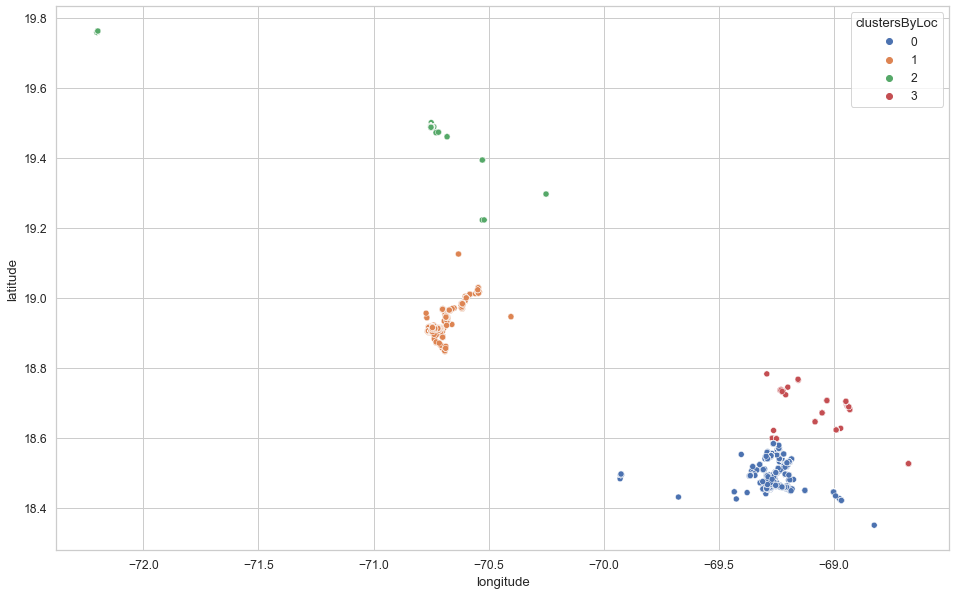

In [60]:
plt.figure(figsize = (16,10))
ax = sns.scatterplot(data = survey_vitals, x = "longitude", y = "latitude", hue = "clustersByLoc", palette = "deep")

# Mergings

### 1. History_env x survey_vitals

In [65]:
survey_environ = survey_vitals.merge(history_env, how = "inner", on = "objectId")

In [66]:
survey_environ.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,city,province,age,sex,...,conditionoRoofinyourhouse,medicalproblemswheredoyougo,dentalproblemswheredoyougo,biggestproblemofcommunity,timesperweektrashcollected,wheretrashleftbetweenpickups,numberofIndividualsLivingintheHouse,numberofChildrenLivinginHouseUndertheAgeof5,houseownership,bathroomAccess
0,lLkC5HGPOC,widow,Ama de casa,lessThanprimary,18.914416,-70.745642,NaN,NaN,67.0,female,...,working,Other Hospital,Other Hospital,Roads,1-2,other,1,0,rented,NaN
1,lLkC5HGPOC,widow,Ama de casa,lessThanprimary,18.914416,-70.745642,NaN,NaN,67.0,female,...,working,Other Hospital,Other Hospital,Roads,1-2,other,1,0,rented,NaN
2,gIoG2SAL99,widow,Other,lessThanprimary,18.914196,-70.746286,NaN,NaN,80.0,male,...,poor,Other Hospital,Dentist,Roads,1-2,other,5,0,owned,NaN
3,gIoG2SAL99,widow,Other,lessThanprimary,18.914196,-70.746286,NaN,NaN,80.0,male,...,poor,Other Hospital,Dentist,Roads,1-2,other,5,0,owned,NaN
4,gIoG2SAL99,widow,Other,lessThanprimary,18.914196,-70.746286,NaN,NaN,80.0,male,...,poor,Other Hospital,Dentist,Roads,1-2,other,5,0,owned,NaN


In [67]:
survey_environ.shape

(7489, 26)